# Best Available Pixel Composite in OpenEO

In this notebook a composite image is created based on the Best Available Pixel (BAP) method in OpenEO. 

First a sample period and region are defined.

In [1]:
spatial_extent = {'west': 4.45, 'east': 4.50, 'south': 51.16, 'north': 51.17, 'crs': 'epsg:4326'}
temporal_extent = ["2022-06-04", "2022-08-01"]

In [2]:
import openeo
import xarray
import numpy as np

from openeo.processes import if_, is_nan

In [3]:
c=openeo.connect("openeo.vito.be").authenticate_oidc()

Authenticated using refresh token.


In [4]:
scl = c.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=spatial_extent,
    temporal_extent=temporal_extent,
    bands=["SCL"],
    max_cloud_cover=90
)

Next, make sure that all pixels which are NaN are cast to zero. This is necessary for later.

In [5]:
scl = scl.apply(lambda x: if_(is_nan(x), 0, x))

Using a UDF, the SCL layer is converted into a score for each pixel. This score is the weighted average of the day-of-year, distance-to-cloud and coverage score.

In [6]:
score = scl.apply_neighborhood(
    process=openeo.UDF.from_file("to_remove_udf.py"),
    size=[{'dimension': 'x', 'unit': 'px', 'value': 256}, {'dimension': 'y', 'unit': 'px', 'value': 256}],
    overlap=[{'dimension': 'x', 'unit': 'px', 'value': 16}, {'dimension': 'y', 'unit': 'px', 'value': 16}]
)
score = score.rename_labels('bands', ['score'])

Next, the results is download and plotted. This is not a necessary step, but is just shown for illustration.

In [7]:
# score.download('./reference_scores/cloud_score.nc')

In [10]:
score_ds = xarray.open_dataset('./reference_scores/cloud_score.nc')
score_ds['score'].values[6,:,:]

array([[0.01212843, 0.01212843, 0.01212843, ..., 0.01212843, 0.01212843,
        0.01212843],
       [0.01212843, 0.0099518 , 0.0099518 , ..., 0.0099518 , 0.0099518 ,
        0.01212843],
       [0.01212843, 0.0099518 , 0.00816257, ..., 0.00816257, 0.0099518 ,
        0.01212843],
       ...,
       [0.01212843, 0.0099518 , 0.00816257, ..., 0.00816257, 0.0099518 ,
        0.01212843],
       [0.01212843, 0.0099518 , 0.0099518 , ..., 0.0099518 , 0.0099518 ,
        0.01212843],
       [0.01212843, 0.01212843, 0.01212843, ..., 0.01212843, 0.01212843,
        0.01212843]])

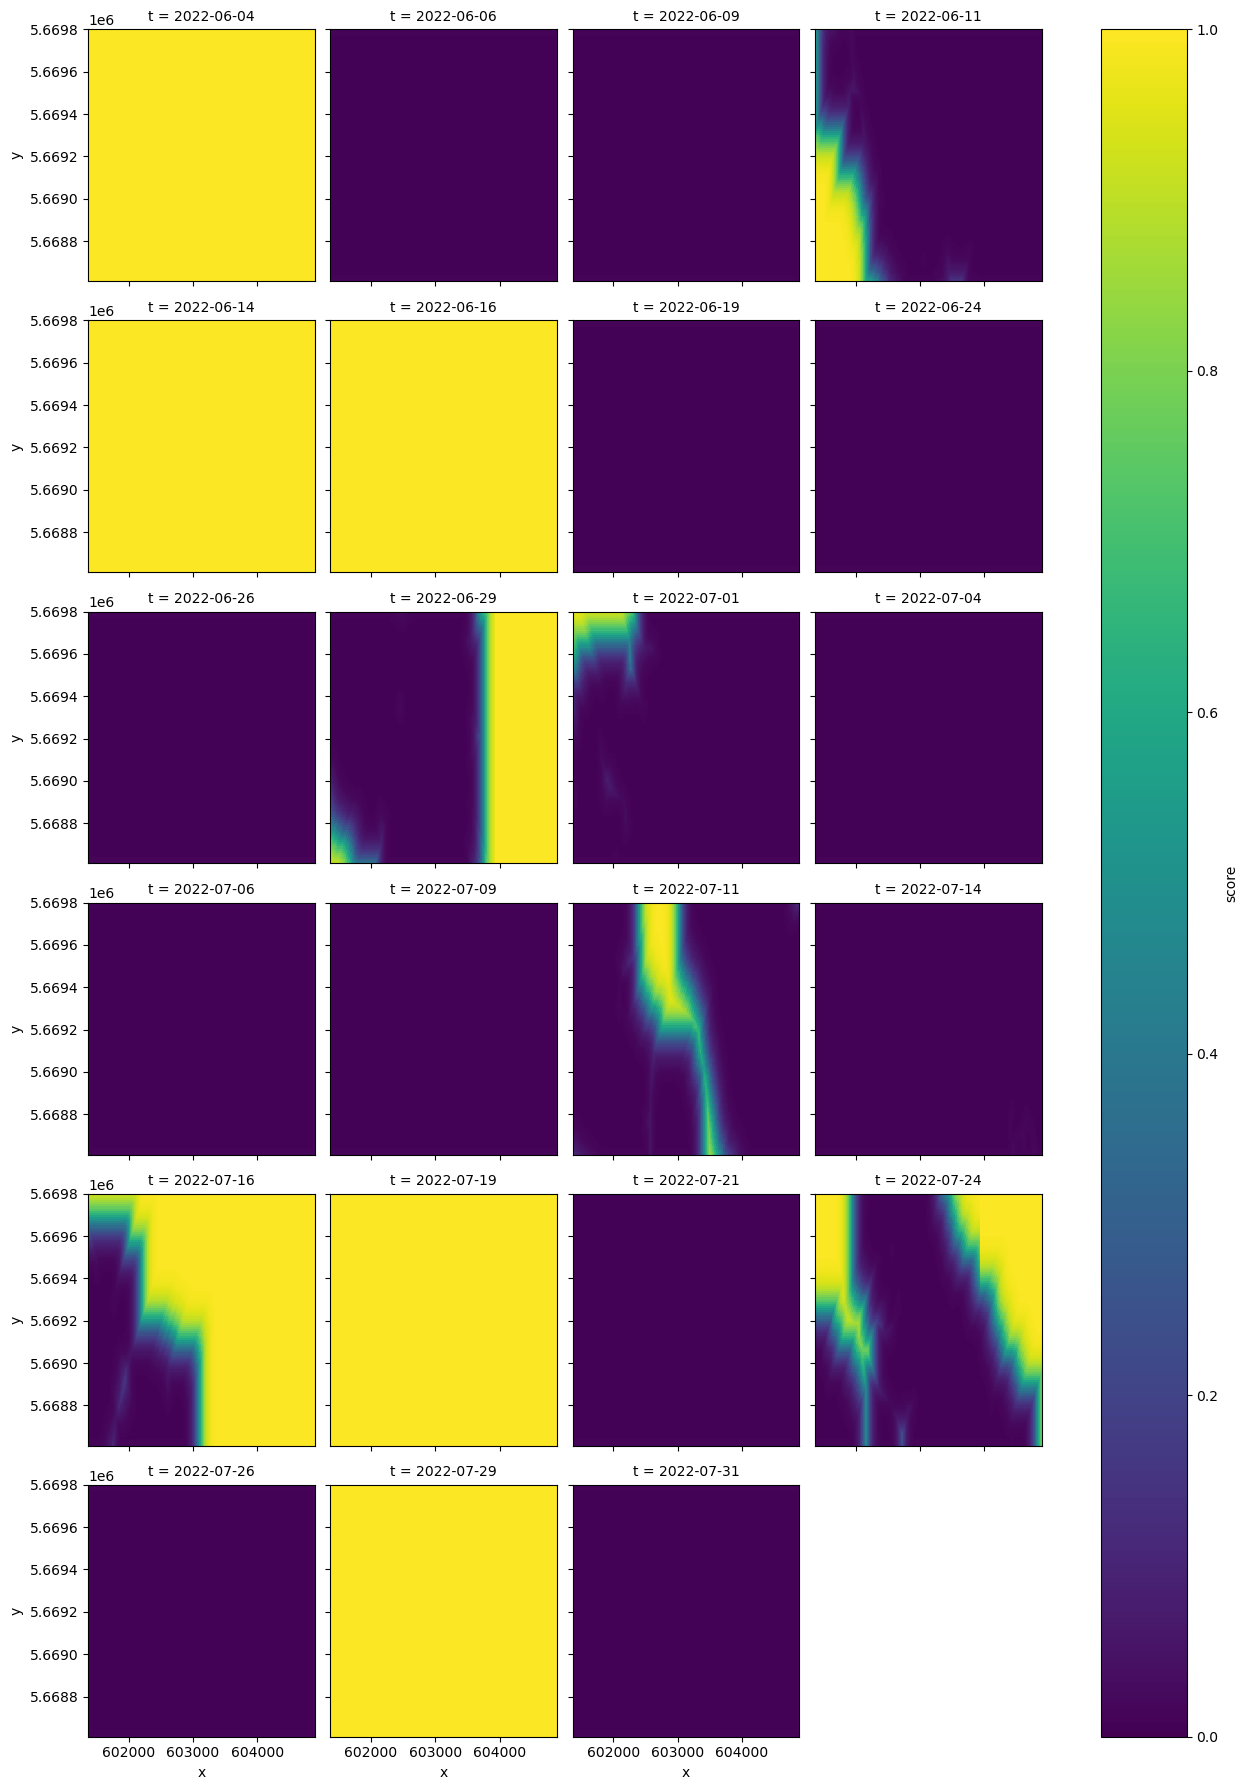

In [11]:
score_ds['score'].plot(vmin=0,vmax=1,col="t",col_wrap=4)

Next, a mask is created. This serves to mask every pixel, except the one with the highest score, for each month.

In [ ]:
def max_score_selection(score):
    max_score = score.max()
    return score.array_apply(lambda x:x!=max_score)

rank_mask = score.apply_neighborhood(
        max_score_selection,
        size=[{'dimension': 'x', 'unit': 'px', 'value': 1}, {'dimension': 'y', 'unit': 'px', 'value': 1},
              {'dimension': 't', 'value': "month"}],
        overlap=[]
    )

Again, the results are downloaded and plotted merely for illustrative purposes only.

In [ ]:
rank_mask.download("./results/rank_mask_udf.nc")

In [ ]:
mask_ds = xarray.open_dataset('./results/rank_mask_udf.nc')
mask_ds

In the plot below, it can be seen that in the month June two days (June 14th and June 16th) are selected by the algorithm. The reason is that all pixels had the highest scores on these days, and furthermore these scores were identical on both days. The situtation where multiple days in a month are selected by the algorithm is handled in the next part.

In [ ]:
mask_ds['score'].plot(vmin=0,vmax=1,col="t",col_wrap=4)

Next, some bands of interest from Sentinel-2 are loaded. They are then masked by the BAP mask constructed above. Then they are aggregated per month, to obtain a composite image per month. By using the "first" process as an aggregator, the situation where there are potentially more than one days in a month selected by the algorithm is immediately handled.

In [ ]:
rgb_bands = c.load_collection(
    "SENTINEL2_L2A",
    temporal_extent = temporal_extent,
    spatial_extent = spatial_extent,
    bands = ["B02", "B03","B04"],
    max_cloud_cover=95
)

composite = rgb_bands.mask(rank_mask).aggregate_temporal_period("month","first")

Next, the final results are downloaded and a composite image for the month of June is shown as an example.

In [ ]:
composite.download('./results/composite_udf.nc')

In [ ]:
composite_ds = xarray.open_dataset('./results/composite_udf.nc')
composite_ds

In [ ]:
rgb_array=composite_ds.to_array(dim="bands").sel(bands=["B04","B03","B02"]).astype(np.float32)/10000
rgb_array

In [ ]:
xarray.plot.imshow(rgb_array.isel(t=0),vmin=0,vmax=0.18,rgb="bands",col_wrap=2)